In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers import Add

In [93]:

def readTextFile(path):
    with open(path) as f:
        caption = f.read()
    return caption

In [94]:
captions = readTextFile(r"C:\Users\DELL\OneDrive\Downloads\archive\captions.txt")


In [95]:
captions = captions.split('\n')[:-1]

In [96]:
captions[161]

'1042020065_fb3d3ba5ba.jpg,A boy in a green shirt is looking down at many inflatable boats .'

In [97]:
desc = {}

for x in captions:
    list1 = x.split(',')
    img_name,img_captions= list1[0],list1[1]
    
    if desc.get(img_name) is None:
        desc[img_name] = []
    desc[img_name].append(img_captions)

In [98]:
desc['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [99]:
import cv2

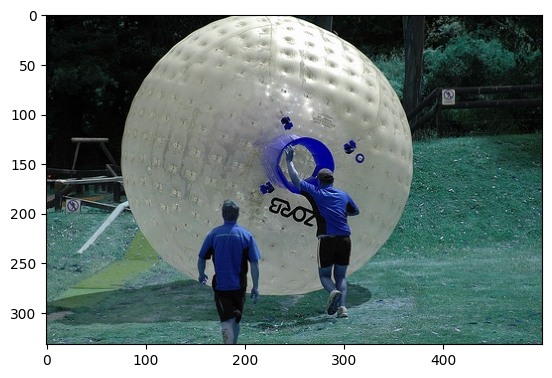

['"A giant inflatable ball ',
 'The men are on a hill with a giant white ball .',
 'Two men are trying to push this very large inflatable golf ball',
 'two men roll a huge ball .',
 'Two workers in orange and black set up bubble']

In [100]:
path = r"C:\Users\DELL\OneDrive\Downloads\archive\Images\96399948_b86c61bfe6.jpg"
plt.imshow(cv2.imread(path))
plt.show()
desc['96399948_b86c61bfe6.jpg']

In [101]:
import re

In [102]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub('[^a-z]+',' ', sentence)
    sentence = sentence.split()
    sentence = [s for s in sentence if len(s) > 1]
    sentence = ' '.join(sentence)
    return sentence

In [103]:
for key, caption_list in desc.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [104]:
desc['1042020065_fb3d3ba5ba.jpg']

['boy in green shirt is looking down at many inflatable boats',
 'boy in green shirt watches kayakers',
 'boy looks over railing at the many boats and rafts below in the water',
 'young boy overlooking crowd of inflatable boats',
 'young boy wearing jersey looks down over ledge at many boats in the water']

In [105]:
# Using a raw string to avoid escape errors
path = r"C:\Users\DELL\OneDrive\Desktop\description.txt"

with open(path, 'w', encoding='utf-8') as f:
    f.write(str(desc))


In [106]:
import json

In [107]:
descriptions = None
with open('C:\\Users\\DELL\\OneDrive\\Desktop\\description.txt') as f:
    descriptions = f.read()
json_acceptable_string = descriptions.replace("'","\"")    
descriptions = json.loads(json_acceptable_string)

In [108]:
print(type(descriptions))

<class 'dict'>


In [109]:
descriptions.get('1042020065_fb3d3ba5ba.jpg')

['boy in green shirt is looking down at many inflatable boats',
 'boy in green shirt watches kayakers',
 'boy looks over railing at the many boats and rafts below in the water',
 'young boy overlooking crowd of inflatable boats',
 'young boy wearing jersey looks down over ledge at many boats in the water']

In [110]:
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size(unique words In Vocab) : %d"% len(vocab))

Vocab Size(unique words In Vocab) : 8258


In [111]:
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words %d"%len(total_words))

Total Words 357792


In [112]:
len(total_words), type(total_words)

(357792, list)

In [113]:
import collections
counter = collections.Counter(total_words)
frq_cnt = dict(counter)
print(len(frq_cnt.keys()))
# print(frq_cnt)

8258


In [114]:
# sort the dictionary according to the freq count

sorted_freq_cnt = sorted(frq_cnt.items(), reverse = True, key=lambda x:x[1])

# filter
threshold =  10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [115]:
#sorted_freq_cnt

In [116]:
print(len(total_words))

1800


In [118]:
descriptions.get('1042020065_fb3d3ba5ba.jpg')

['boy in green shirt is looking down at many inflatable boats',
 'boy in green shirt watches kayakers',
 'boy looks over railing at the many boats and rafts below in the water',
 'young boy overlooking crowd of inflatable boats',
 'young boy wearing jersey looks down over ledge at many boats in the water']

In [135]:
len(descriptions.keys()), len(descriptions.values())

(8091, 8091)

In [142]:
train_file_data = readTextFile("C:\\Users\\DELL\\OneDrive\\Desktop\\train_descriptions.txt")
test_file_data = readTextFile("C:\\Users\\DELL\\OneDrive\\Desktop\\test_descriptions.txt")

In [156]:
import ast

# Step 1: Read train.txt and test.txt as dictionaries
with open(r"C:\\Users\\DELL\\OneDrive\\Desktop\\train_descriptions.txt", 'r') as f:
    train_dict = ast.literal_eval(f.read())

with open(r"C:\\Users\\DELL\\OneDrive\\Desktop\\test_descriptions.txt", 'r') as f:
    test_dict = ast.literal_eval(f.read())

# Step 2: Extract image IDs without '.jpg'
train_ids = [key.split('.')[0] for key in train_dict.keys()]
test_ids = [key.split('.')[0] for key in test_dict.keys()]

# Step 3: Print result
print(f" Extracted {len(train_ids)} train image IDs and {len(test_ids)} test image IDs.")
print("Sample Train IDs:", train_ids[:5])


 Extracted 5999 train image IDs and 2092 test image IDs.
Sample Train IDs: ['1000268201_693b08cb0e', '1001773457_577c3a7d70', '1002674143_1b742ab4b8', '1003163366_44323f5815', '1007129816_e794419615']


In [158]:
train_descriptions = {}
for img_id in train_ids:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id+'.jpg']:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [159]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [160]:
model = ResNet50(weights = 'imagenet', input_shape = (224,224,3))
model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [161]:
model_new = Model(model.input,model.layers[-2].output)

In [162]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].


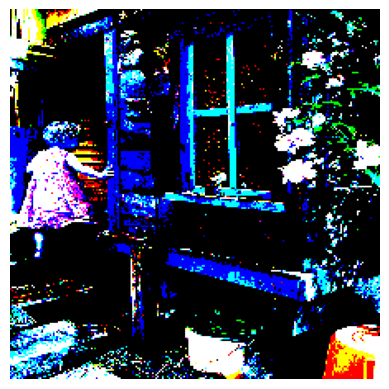

In [166]:
import os
import matplotlib.pyplot as plt

# Set image ID and base path
img_id = "1000268201_693b08cb0e.jpg"
base_path = r'C:\Users\DELL\OneDrive\Downloads\archive\Images'

# Build full path
img_path = os.path.join(base_path, img_id)

# Preprocess and show the image
img = preprocess_img(img_path)
plt.imshow(img[0])
plt.axis("off")
plt.show()


In [167]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)  
    feature_vector = feature_vector.reshape((2048,))
    #print(feature_vector.shape)
    return feature_vector

In [168]:
import os

image_id = "1000268201_693b08cb0e.jpg"
image_path = os.path.join(r'C:\Users\DELL\OneDrive\Downloads\archive\Images', image_id)

encoded = encode_image(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [171]:
start = time()
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image
for ix,img_id in enumerate(train_ids):
    img_path = 'C:\\Users\\DELL\\OneDrive\\Downloads\\archive\\Images'+"\\"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    if ix%100==0:
        print("Encoding in progress time step %d "%ix)
end_t = time()
print("Total Time Taken :",end_t-start)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
Encoding in progress time step 0 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22

In [172]:
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image
for ix,img_id in enumerate(test_ids):
    img_path = 'C:\\Users\\DELL\\OneDrive\\Downloads\\archive\\Images'+"\\"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    if ix%100==0:
        print("Encoding in progress time step %d "%ix)
end_t = time()
print("Total Time Taken :",end_t-start)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
Encoding in progress time step 0 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12

In [173]:
import pickle

with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [174]:
len(total_words)

1800

In [175]:
word_to_idx = {}
idx_to_word = {}

for i, word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [176]:
word_to_idx['dog']
idx_to_word[1]

'in'

In [177]:
len(idx_to_word)

1800

In [178]:
idx_to_word[1801] = 'startseq'
word_to_idx['startseq'] = 1801

idx_to_word[1802] = 'endseq'
word_to_idx['endseq'] = 1802

In [179]:
vocab_size =len(word_to_idx)+1
print(vocab_size)

1803


In [180]:
max_len = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

31


In [234]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size):
    X1, X2, y = [], [], []
    n = 0

    while True:
        for key, desc_list in train_descriptions.items():
            if key not in encoding_train:
                continue

            n += 1
            photo = encoding_train[key]

            for desc in desc_list:
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1, len(seq)):
                    xi = seq[:i]
                    yi = seq[i]

                    xi = pad_sequences([xi], maxlen=max_len, padding='post')[0]
                    yi = to_categorical([yi], num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)

            if n == batch_size:
                yield ((np.array(X1), np.array(X2)), np.array(y))  # ✅ tuple of tuple
                X1, X2, y = [], [], []
                n = 0


In [235]:
f = open(r"C:\Users\DELL\OneDrive\Downloads\glove.6B\glove.6B.50d.txt", encoding='utf8')


In [236]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding
    

In [237]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [238]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [239]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1803, 50)

In [240]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [241]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [242]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [243]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)    │ (None, 31)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_7 (InputLayer)    │ (None, 2048)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_2 (Embedding)       │ (None, 31, 50)            │          90,150 │ input_layer_8[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_4 (Dropout)           │ (None, 2048)              │               0 │ input_layer_7[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_5 (Dropout)           │ (None, 31, 50)            │               0 │ embedding_2[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal_2 (NotEqual)        │ (None, 31)                │               0 │ input_layer_8[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 256)               │         524,544 │ dropout_4[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_2 (LSTM)                 │ (None, 256)               │         314,368 │ dropout_5[0][0],           │
│                               │                           │                 │ not_equal_2[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_2 (Add)                   │ (None, 256)               │               0 │ dense_6[0][0],             │
│                               │                           │                 │ lstm_2[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_7 (Dense)               │ (None, 256)               │          65,792 │ add_2[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_8 (Dense)               │ (None, 1803)              │         463,371 │ dense_7[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,458,225 (5.56 MB)

 Trainable params: 1,458,225 (5.56 MB)

 Non-trainable params: 0 (0.00 B)

In [257]:
# Embedding Layer most important
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [258]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

In [286]:
epochs = 20
batch_size = 32
steps = len(train_descriptions)//batch_size

In [260]:
import pydot
import graphviz
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)


You must install pydot (`pip install pydot`) for `plot_model` to work.


In [287]:
import os

def train():
    save_path = r'C:\Users\DELL\model_weights'
    os.makedirs(save_path, exist_ok=True)

    for i in range(epochs):
        print(f"🔁 Epoch {i+1}/{epochs}")
        
        generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size)
        
        model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

        model_path = os.path.join(save_path, f'model_{i}.keras')  # ✅ extension tells format
        model.save(model_path)  # ✅ remove deprecated save_format
        print(f"✅ Saved model to: {model_path}")


In [288]:
train()

🔁 Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - loss: 3.9018
✅ Saved model to: C:\Users\DELL\model_weights\model_0.keras
🔁 Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - loss: 3.6116
✅ Saved model to: C:\Users\DELL\model_weights\model_1.keras
🔁 Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 245s 1s/step - loss: 3.4248
✅ Saved model to: C:\Users\DELL\model_weights\model_2.keras
🔁 Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 761s 4s/step - loss: 3.2898
✅ Saved model to: C:\Users\DELL\model_weights\model_3.keras
🔁 Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - loss: 3.1792
✅ Saved model to: C:\Users\DELL\model_weights\model_4.keras
🔁 Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 759s 4s/step - loss: 3.0896
✅ Saved model to: C:\Users\DELL\model_weights\model_5.keras
🔁 Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - loss: 3.0172
✅ Saved model to: C:\Users\DELL\model_weights\model_6.keras
🔁 Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - loss: 2.9483
✅ Saved model to: C:

In [279]:
from tensorflow.keras.models import load_model

model = load_model(r"C:\Users\DELL\model_weights\model_19.keras")


In [280]:
def predict_caption(photo):
    in_text = "startseq"
    
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        ypred = model.predict([photo, sequence], verbose=0)
        ypred = ypred.argmax()

        word = idx_to_word.get(ypred, None)
        if word is None:
            break

        in_text += ' ' + word

        if word == "endseq":
            break

    # Remove startseq and endseq tokens
    final_caption = in_text.split()[1:-1]
    return ' '.join(final_caption)


In [281]:
import matplotlib.pyplot as plt
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


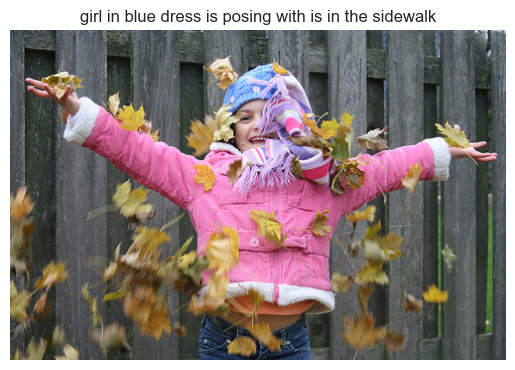

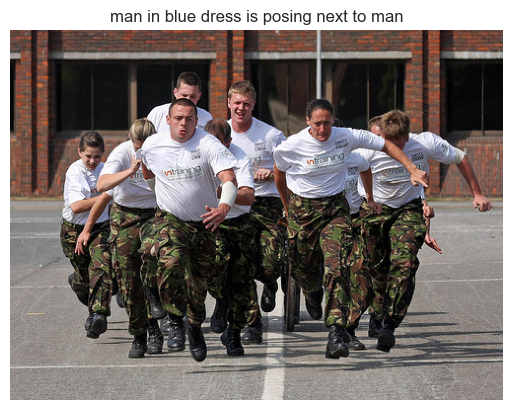

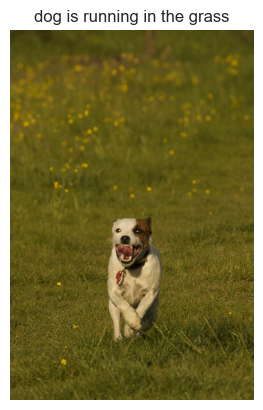

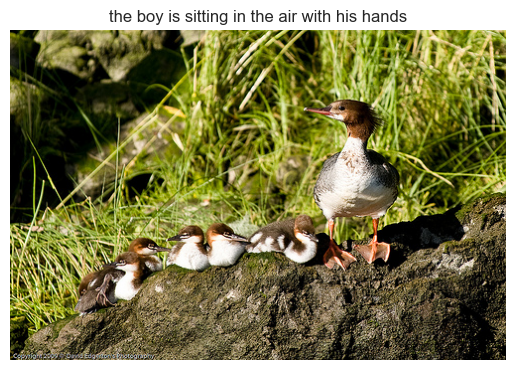

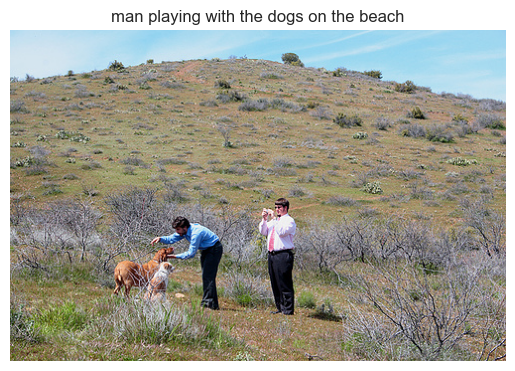

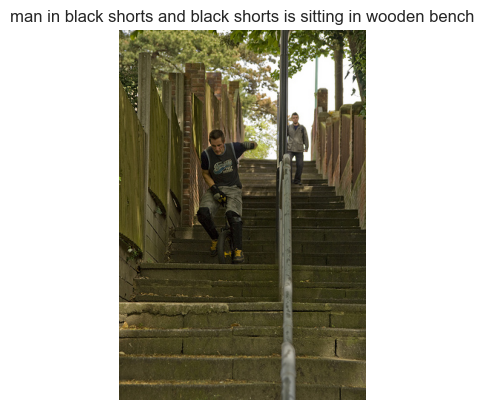

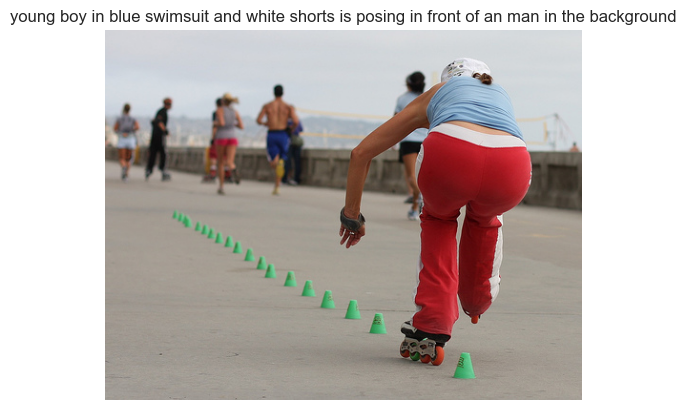

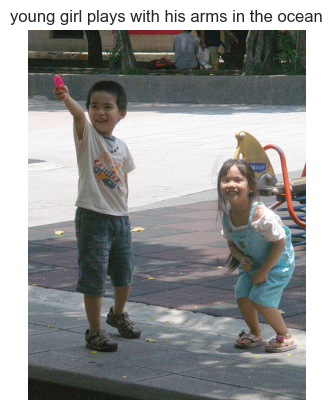

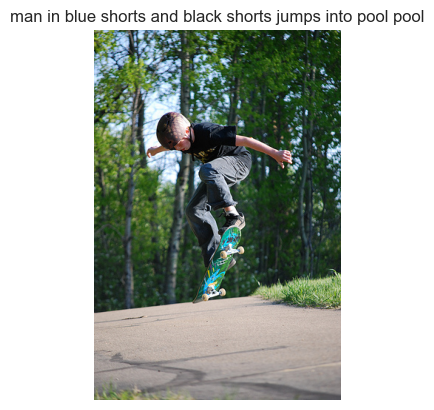

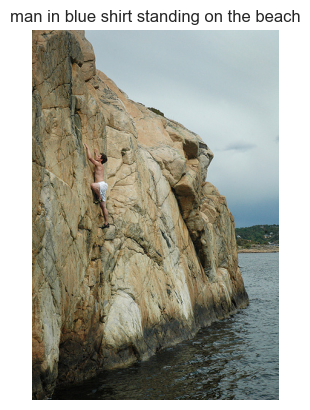

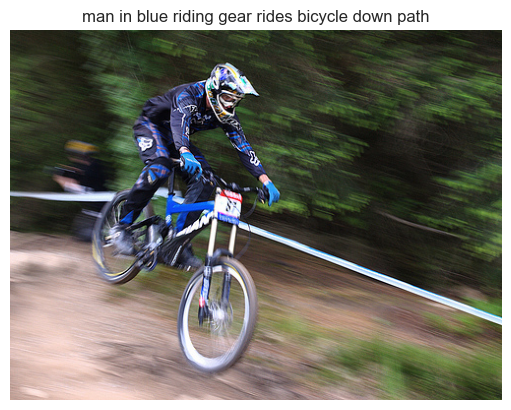

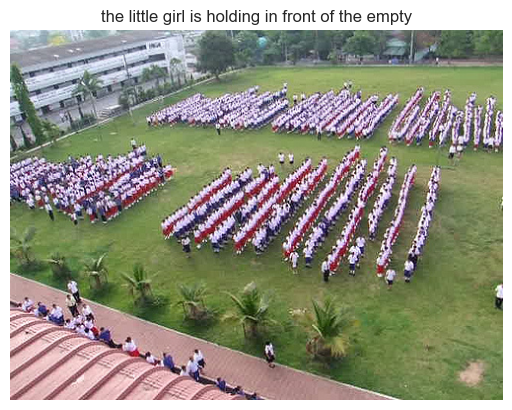

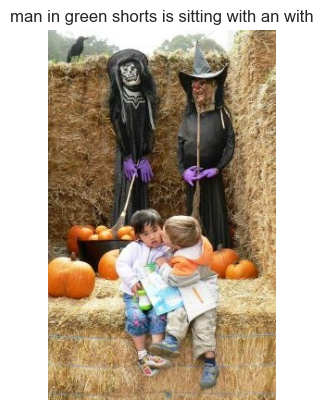

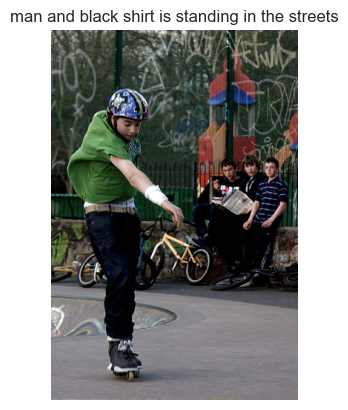

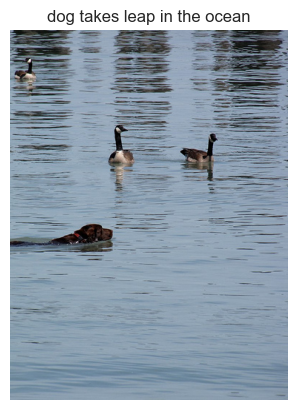

In [282]:
plt.style.use("seaborn-v0_8-darkgrid")
for _ in range(15):
    idx = np.random.randint(0, 1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1, 2048))

    img_path = r"C:\Users\DELL\OneDrive\Downloads\archive\Images\\" + img_name + ".jpg"
    img = plt.imread(img_path)

    caption = predict_caption(photo_2048)

    plt.title(caption)
    plt.imshow(img)
    plt.axis("off")
    plt.show() 